# Active Learning Guide

TBD.

## Setup

In [52]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [54]:
IMAGE_MIN_SIZE = 64
TRAIN_RATIO = 0.2
BATCH_SIZE = 64

In [55]:
from data_utils import (
    build_resized_image_folder,
    build_paths_and_labels,
    train_test_val_pool_split,
    CustomDataset,
    IMAGENET_MEAN,
    IMAGENET_STD,
    visualize_batch,
)

In [56]:
# Resize images to 64px their smallest side and save to new folder.
# This will accelerate training, since the purpose is to show how active learning works.
dataset_root = Path("./data/flowers")
build_resized_image_folder(
    src_root=dataset_root / "train",
    dst_root=dataset_root / f"train_{IMAGE_MIN_SIZE}",
    min_side=IMAGE_MIN_SIZE,
    overwrite=False,
)

Processing images: 100%|██████████| 2751/2751 [00:03<00:00, 828.87it/s]

Done. Processed 2746 images. Wrote 0 resized images to: data\flowers\train_64


In [57]:
# Given the root path, get lists of paths and labels
paths, labels, classe_names, class_to_id = build_paths_and_labels(dataset_root / f"train_{IMAGE_MIN_SIZE}")

In [58]:
print(f"Number of paths: {len(paths)}")
print(f"Classes: {classe_names}")
print(f"Class to index mapping: {class_to_id}")
print(f"First path: {paths[0]}")
print(f"First label (int, id): {labels[0]}")
print(f"First label (str): {classe_names[labels[0]]}")

Number of paths: 2746
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class to index mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
First path: data\flowers\train_64\daisy\10140303196_b88d3d6cec.jpg
First label (int, id): 0
First label (str): daisy


In [59]:
# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [60]:
print(f"Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Train size: 548
Val size: 276
Test size: 276
Pool size: 1646


In [61]:
# Transforms
train_transform = T.Compose([
    T.Resize((IMAGE_MIN_SIZE, IMAGE_MIN_SIZE)),
    T.RandomApply([T.RandomRotation(degrees=15)], p=0.7),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.10, 0.10))], p=0.7),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transform = T.Compose([
    T.Resize((IMAGE_MIN_SIZE, IMAGE_MIN_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [62]:
# Auxiliary factory function to create DataLoaders
# If not Windows, set num_workers > 0 for faster data loading.
# If CUDA is available, set pin_memory=True for faster data transfer to GPU.
def make_loader(ds, batch_size=16, shuffle=False, num_workers=1, pin_memory=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

In [63]:
# Datasets and loaders
train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
test_ds = CustomDataset(paths, labels, test_idx,  transform=eval_transform)
pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)

train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
pool_loader = make_loader(pool_ds, batch_size=BATCH_SIZE, shuffle=False)

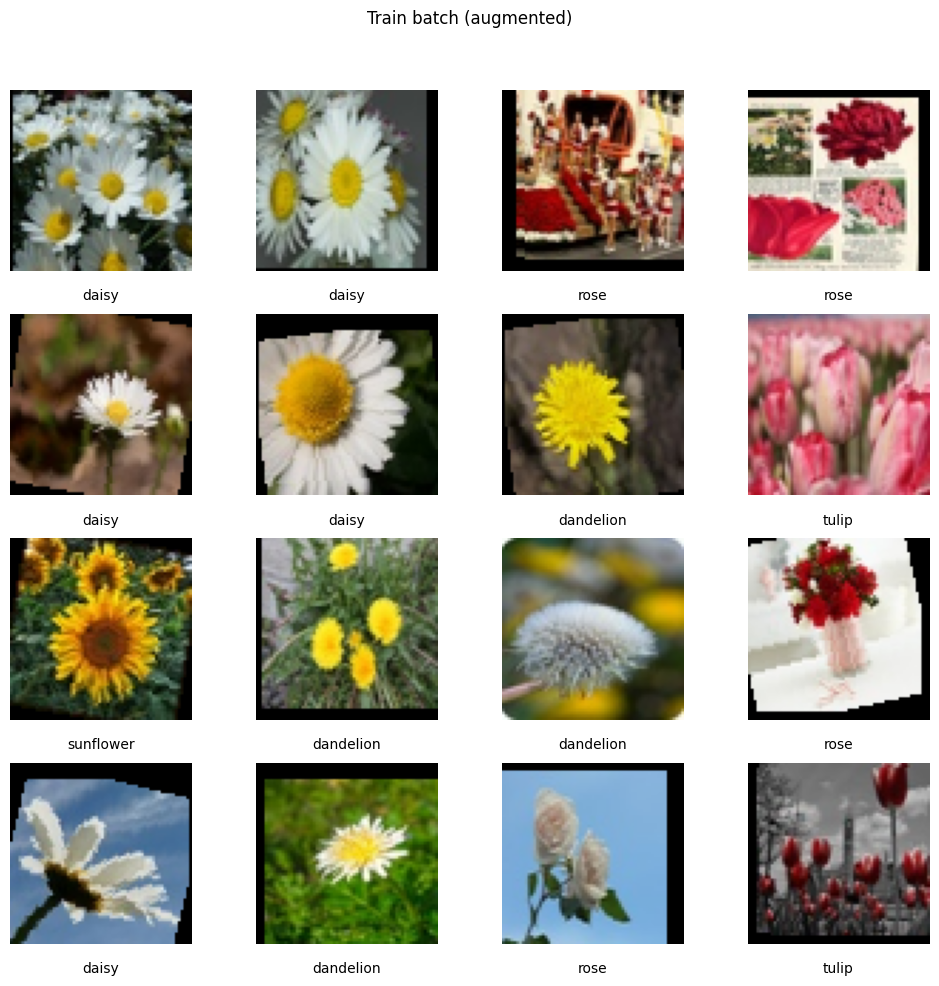

In [84]:
batch = next(iter(train_loader))
visualize_batch(batch, class_names=classe_names, title="Train batch (augmented)")

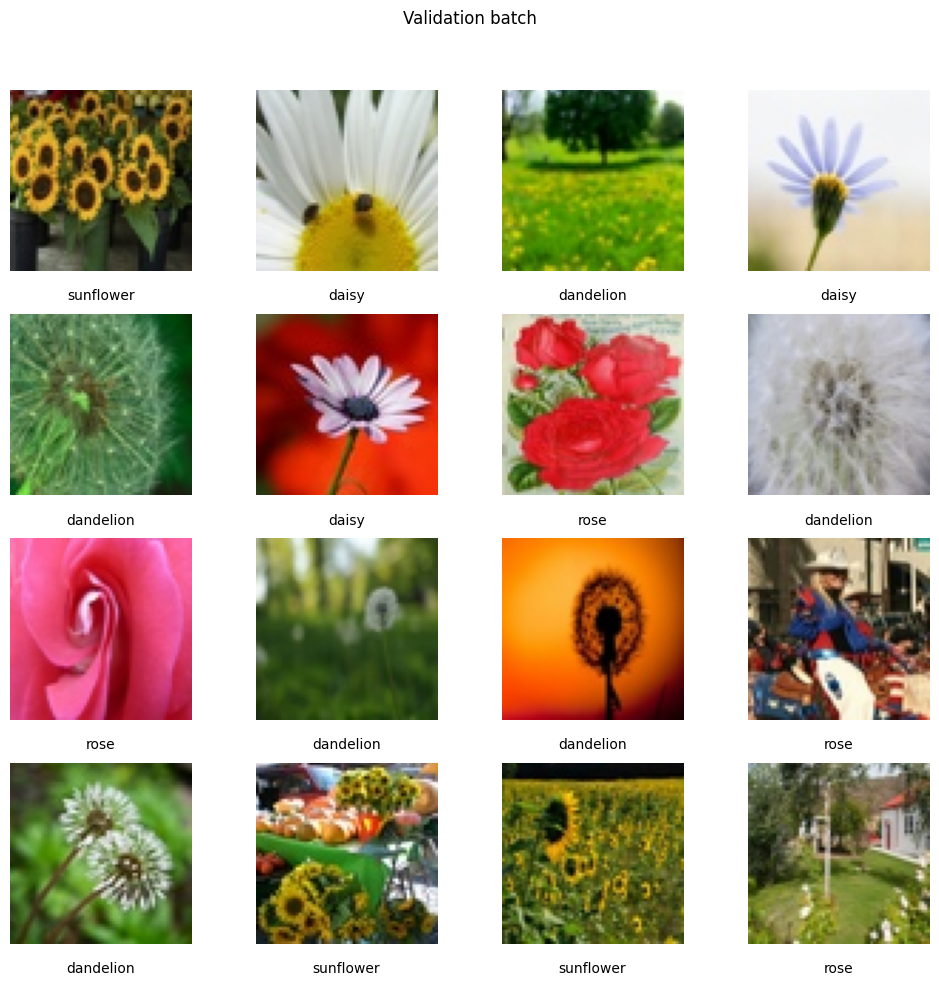

In [85]:
batch = next(iter(val_loader))
visualize_batch(batch, class_names=classe_names, title="Validation batch")

## Model and Training

In [66]:
from model_utils import (
    SimpleCNN,
    TrainConfig,
    train,
    evaluate,
    plot_history,
    load_model,
    predict,
    predict_image,
)

In [67]:
# model
model = SimpleCNN(num_classes=len(classe_names))

In [68]:
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=T

In [ ]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [83]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.140625

In [86]:
# Training Configuration
cfg = TrainConfig(
    num_classes=len(classe_names),
    epochs=15,
    lr=1e-3,
    batch_size=BATCH_SIZE,
    out_dir="runs/flowers_cnn",
    run_name=f"train_ratio_{TRAIN_RATIO}",
    metric_for_best="val_acc",
    maximize_metric=True,
)

In [87]:
# Train the model!
history = train(model, train_loader, val_loader, cfg)

Training epochs:   7%|▋         | 1/15 [00:19<04:36, 19.72s/it]

Epoch 001/15 | train_loss=2.8751 train_acc=0.307 | val_loss=1.4641 val_acc=0.380 | lr=1.00e-03


Training epochs:  13%|█▎        | 2/15 [00:36<03:53, 17.93s/it]

Epoch 002/15 | train_loss=1.3913 train_acc=0.442 | val_loss=1.2604 val_acc=0.471 | lr=1.00e-03


Training epochs:  20%|██        | 3/15 [00:52<03:27, 17.30s/it]

Epoch 003/15 | train_loss=1.2106 train_acc=0.495 | val_loss=1.2204 val_acc=0.507 | lr=1.00e-03


Training epochs:  27%|██▋       | 4/15 [01:09<03:05, 16.86s/it]

Epoch 004/15 | train_loss=1.1527 train_acc=0.526 | val_loss=1.1962 val_acc=0.518 | lr=1.00e-03


Training epochs:  33%|███▎      | 5/15 [01:26<02:49, 16.91s/it]

Epoch 005/15 | train_loss=1.1144 train_acc=0.536 | val_loss=1.1555 val_acc=0.543 | lr=1.00e-03


Training epochs:  40%|████      | 6/15 [01:42<02:32, 16.89s/it]

Epoch 006/15 | train_loss=1.0477 train_acc=0.571 | val_loss=1.1570 val_acc=0.543 | lr=1.00e-03


Training epochs:  47%|████▋     | 7/15 [02:00<02:15, 16.96s/it]

Epoch 007/15 | train_loss=1.0111 train_acc=0.580 | val_loss=1.1400 val_acc=0.547 | lr=1.00e-03


Training epochs:  53%|█████▎    | 8/15 [02:17<01:59, 17.08s/it]

Epoch 008/15 | train_loss=1.0007 train_acc=0.577 | val_loss=1.1240 val_acc=0.558 | lr=1.00e-03


Training epochs:  60%|██████    | 9/15 [02:33<01:41, 16.88s/it]

Epoch 009/15 | train_loss=0.9726 train_acc=0.611 | val_loss=1.1118 val_acc=0.569 | lr=1.00e-03


Training epochs:  67%|██████▋   | 10/15 [02:49<01:23, 16.63s/it]

Epoch 010/15 | train_loss=0.9489 train_acc=0.617 | val_loss=1.0795 val_acc=0.580 | lr=1.00e-03


Training epochs:  73%|███████▎  | 11/15 [03:06<01:06, 16.72s/it]

Epoch 011/15 | train_loss=0.9119 train_acc=0.622 | val_loss=1.0873 val_acc=0.594 | lr=1.00e-03


Training epochs:  80%|████████  | 12/15 [03:23<00:50, 16.68s/it]

Epoch 012/15 | train_loss=0.8709 train_acc=0.617 | val_loss=1.0887 val_acc=0.594 | lr=1.00e-03


Training epochs:  87%|████████▋ | 13/15 [03:44<00:35, 17.92s/it]

Epoch 013/15 | train_loss=0.8803 train_acc=0.644 | val_loss=1.0423 val_acc=0.598 | lr=1.00e-03


Training epochs:  93%|█████████▎| 14/15 [04:07<00:19, 19.62s/it]

Epoch 014/15 | train_loss=0.8285 train_acc=0.662 | val_loss=0.9895 val_acc=0.620 | lr=1.00e-03


Training epochs: 100%|██████████| 15/15 [04:28<00:00, 17.91s/it]

Epoch 015/15 | train_loss=0.8364 train_acc=0.672 | val_loss=1.0722 val_acc=0.601 | lr=1.00e-03


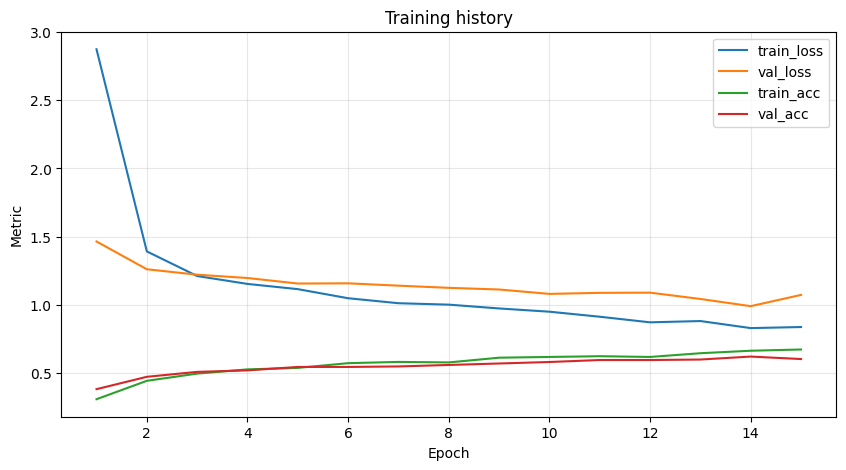

In [88]:
# Plot learning curves
plot_history(history)

In [89]:
# Evaluate best checkpoint
device = torch.device(cfg.device)
ckpt = load_model(Path(cfg.out_dir) / cfg.run_name / "best.pt", model, map_location=cfg.device)
test_metrics = evaluate(model.to(device), test_loader, device)

In [90]:
print(test_metrics)

{'test_loss': 0.9970497730849446, 'test_acc': 0.6195652173913043}


In [91]:
# Single Pass
batch = next(iter(val_loader))
images, labels = batch
label_names = [classe_names[l] for l in labels]
preds = predict(
    model=model,
    batch=batch,
    device="cpu",
    class_names=classe_names,
)

In [93]:
# Accuracy for the batch
sum([1 if p == l else 0 for p, l in zip(preds, label_names)]) / len(preds)

0.640625